# Studying modern hip-hop artists with network science and natural language processing

*A group assignment for the course 02805 Social graphs and interactions at the Technical university of Denmark.*

## Short summary of the notebook

Please click on the links to go to the part.

1. [Collecting the data](#Data-collection)
1. [Constructing the graph](#Graph-construction)
1. [Analyzing the network](#Network-analysis)

In [1]:
import re, requests, json, itertools, operator, nltk, codecs, csv
#import lyricsgenius

import numpy             as np
import matplotlib.pyplot as plt
import networkx          as nx
import networkx.algorithms.community as nxcom

from tqdm                import tqdm
from requests.exceptions import ReadTimeout
from wordcloud           import STOPWORDS

The ``lyricsgenius`` package needs to be installed by running (Git needs to be installed):

In [ ]:
#!pip install git+https://github.com/johnwmillr/LyricsGenius.git

## Data collection

Below is the code that was used to download the data from Wikipedia, Spotify, and Genius.
It does not need to be run since the data has already been collected. Click [here](#Graph-construction) to skip it.

#### From Wikipedia

#### From Spotify

#### From Genius

#### From API Ninjas

## Graph construction

- The graph is directed
- Every node corresponds to one artist
- An edge exists between two nodes if and only if the two corresponding artists are featured on a song

Note: we first compute the attributes of the nodes, so the actual graph construction is at the end of the folllowing cell.

In [9]:
# Loading the data -------------------------------------------------------------------------------------------------------------

with codecs.open("data_final.txt", 'r', "utf-8") as f:
    artist_data = json.load(f)

with codecs.open("lyrics_best.txt", 'r', "utf-8") as f:
    lyrics = json.load(f)

with codecs.open("networth_data.txt", 'r', "utf-8") as f:
    networth_data = json.load(f)
    
# NLP for the lyrics, as node attributes ---------------------------------------------------------------------------------------

# Getting the most frequent words from an artist's lyrics, as well as computing the lexical richness
attributes = {}

for artist in lyrics:
    if len(lyrics[artist]) > 0:
        # Filtering out the stop words
        text = [w for w in lyrics[artist] if w not in STOPWORDS]
        # Creating the frequency distribution
        fdist = nltk.FreqDist(text)
        info = {}
        # Computing the lexical richness of an artist's lyrics
        info["voc"] = len(set(lyrics[artist]))/len(lyrics[artist])*100            
        info["txt"] = len(lyrics[artist])
        # Getting the most common words in the distribution
        results = fdist.most_common()
        for i in range(15):
            if i < len(results):
                (w, _) = results[i]
                info["word"+str(i+1)] = w
            else:
                break
        attributes[artist] = info
    
# Graph construction -----------------------------------------------------------------------------------------------------------

G = nx.DiGraph()

exceptions = []
for artist in artist_data:
    G.add_node(artist)
    try:
        for featured_artist in artist_data[artist][2]:
            if featured_artist in artist_data and featured_artist != artist:
                G.add_edge(artist, featured_artist)
    except:
        exceptions.append(artist)
        
nx.set_node_attributes(G, attributes)

## Network analysis

We first analyzed the network by using the tools from the ``networkx`` package. While looking for a faster and easier way to  visualize the graph, we found a free software called **Gephi**, which turned out to also have the tools needed to perform some analysis on the graph. So we used both of those tools. However, since the software does not need the user to write any code, we have just its results to show for it.

The software can open graphs saved as ``.gml`` so we do it below.

In [4]:
#nx.write_gml(G, "artists_graph.gml")
G = nx.read_gml("artists_graph.gml")

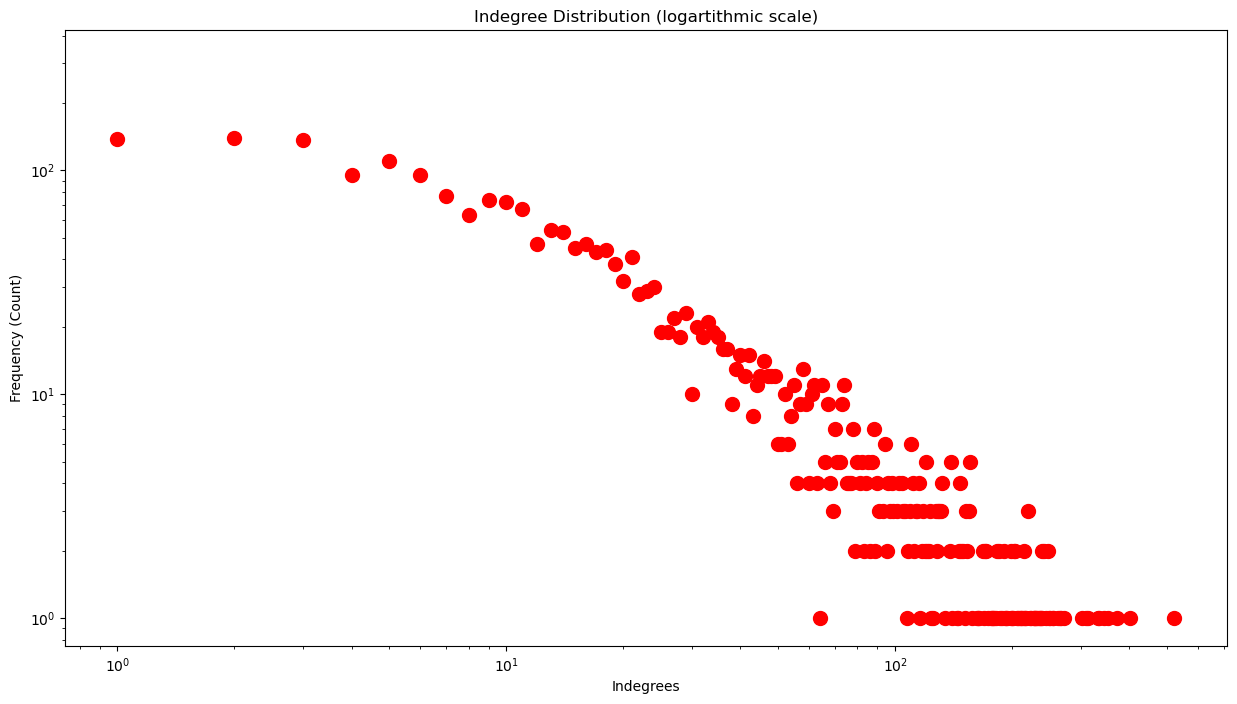

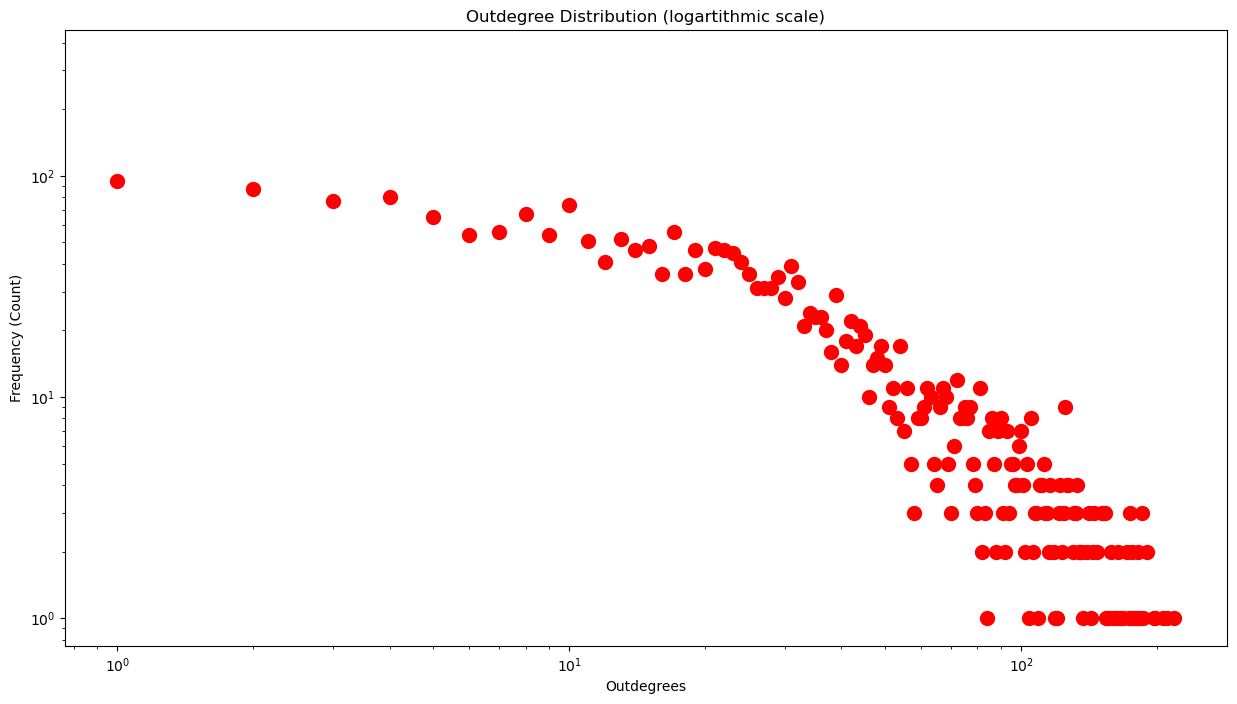

Highest degrees:
[('snoop dogg', 522), ('lil wayne', 402), ('gucci mane', 372), ('wiz khalifa', 353), ('rick ross', 344), ('busta rhymes', 335), ('2 chainz', 333), ('lil baby', 313), ('future', 310), ('e-40', 303)]
[("lil' cease", 218), ('mos def', 210), ('sheck wes', 206), ('treach', 198), ('rah digga', 197), ('memphis bleek', 190), ('i-20', 190), ('playboi carti', 186), ('inspectah deck', 185), ('slick rick', 185)]



In [11]:
# Descriptive analysis ---------------------------------------------------------------------------------------------------------

# Computing different statistics
indegree_distribution      = sorted((d for n, d in G.in_degree()), reverse=True)
outdegree_distribution     = sorted((d for n, d in G.out_degree()), reverse=True)
indegree_mean              = np.mean(indegree_distribution)
outdegree_mean             = np.mean(outdegree_distribution)
indegree_median            = np.median(indegree_distribution)
outdegree_median           = np.median(outdegree_distribution)
indegree_mode              = max(set(indegree_distribution), key=indegree_distribution.count)
outdegree_mode             = max(set(outdegree_distribution), key=outdegree_distribution.count)
indegree_min               = min(indegree_distribution)
outdegree_min              = min(outdegree_distribution)
indegree_max               = max(indegree_distribution)
outdegree_max              = max(outdegree_distribution)

indegree_dist = dict([(degree[0], len(list(degree[1]))) for degree in itertools.groupby(indegree_distribution)])
outdegree_dist = dict([(degree[0], len(list(degree[1]))) for degree in itertools.groupby(outdegree_distribution)])

def plot_degrees(x, y, title, xaxis, yaxis='Frequency (Count)', figsize=(10, 7)):
    '''
    Plotting function for the degree distributions
    '''
    plt.figure(figsize=figsize)
    # We use a log-log scale to show the scale-free property
    plt.loglog(x, y, color='r', linestyle='None', markersize = 10.0, marker='o')
    #plt.plot(x, y, color='r', linestyle='None', markersize = 10.0, marker='o')
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.show()

plot_degrees(indegree_dist.keys(), indegree_dist.values(), title='Indegree Distribution (logartithmic scale)',
             xaxis='Indegrees', figsize=(15, 8))
plot_degrees(outdegree_dist.keys(), outdegree_dist.values(), title='Outdegree Distribution (logartithmic scale)',
             xaxis='Outdegrees', figsize=(15, 8))

print("Highest degrees:")
print(sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:10])
print(sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:10])
print("")

# Betweness Centrality
betweness_centrality = nx.betweenness_centrality(G)
max_betweness_centrality = max(betweness_centrality.items(), key=operator.itemgetter(1))[0]
print("Highest betweness centrality:")
print(max_betweness_centrality, betweness_centrality[max_betweness_centrality])
print("")

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)
max_closeness_centrality = max(closeness_centrality.items(), key=operator.itemgetter(1))[0]
print("Highest closeness centrality:")
print(max_closeness_centrality, closeness_centrality[max_closeness_centrality])
print("")


#Plotting the Networth Data
networth_artists = list(networth_data.keys())
degree_data = dict(sorted(G.in_degree, key=lambda x: x[1], reverse=True))
extracted_data = [(degree_data[artist], networth_data[artist]) for artist in networth_artists if artist in list(degree_data.keys())]
degrees = dict(extracted_data).keys()
networth = dict(extracted_data).values()


plt.figure(figsize=(12,10))
plt.scatter(networth, degrees)
plt.title('Networth vs Indegrees')
plt.plot(10**8.175, 522, 'go')
plt.xscale('log')
plt.xlabel('Networth in log scale')
plt.ylabel('Number of indegrees')
plt.show()




# Sentiment analysis on the lyrics ---------------------------------------------------------------------------------------------

# Storing the sentiment values of words from the labMT wordlist
happiness = {}

with open('labMT.txt') as f:
    for w, h in re.findall(r'([a-z]+)\t\d+\t([\d.]+)', f.read()):
        happiness[w] = float(h)

# That way we have a value reference:
#    8.50 is the highest happiness
#    1.30 is the lowest

def computeHappiness(fd):
    '''
    Computes the total happiness of a text given its FreqDist "fd", and the word list "happiness"
    '''
    h = 0
    nb_words_recognized = 0
    for w in fd:
        # We use a try-except structure here because some words don't have a happiness value
        try:
            # We just weigh the value by the word's frequency
            h += (happiness[w] * fd[w])
            # We count how many words are recognized because we will use this to normalize the result
            nb_words_recognized += fd[w]
        except KeyError:
            pass
    return h, nb_words_recognized

# This is the part that computes the happiness for every character of the graph (for which at least one word was recognized)
artists_happiness = {}
for artist in lyrics: 
    # Removing the stop words from the lyrics
    text = [w for w in lyrics[artist] if w not in STOPWORDS]
    # Creating the frequency distribution
    fd = nltk.FreqDist(text)   
    h, l = computeHappiness(fd)
    # If not a single word was recognized, it's useless
    if l > 0:
        artists_happiness[artist] = (h/l)
        
# Communities ------------------------------------------------------------------------------------------------------------------

# Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)

# Count the communities
print(f"NX algorithm: {len(communities)} communities found.")

# We also used the Louvain algorithm implemented in the community package to detect the communities
import community
H = G.to_undirected()
partition = community.best_partition(H)
print("Louvain algorithm: ", len(set(partition.values())), "communities found,")
modularity = community.modularity(partition, H)
print("and Modularity =", modularity)

# Grouping the artists by communities in order to compute statistics
communities = {}
for i in range(max(partition.values())+1):
    communities[i] = []
for artist in partition:
    communities[partition[artist]].append(artist)

# Comparing the communities: number of artists, lexical richness, average degree, most used words
for i in communities:
    if len(communities[i]) > 1:
        print("Community", i, ":", len(communities[i]), "artists")
        avg_lex = 0
        lex_count = 0
        for artist in communities[i]:
            try:
                avg_lex += attributes[artist]["voc"]
                lex_count += 1
            except:
                pass
        try:
            print(lex_count, "artists taken into account -> Average lexical richness =", avg_lex/lex_count)
        except:
            pass
        
        text = []
        degree_count = 0
        degree = 0
        for artist in communities[i]:
            try:
                text += lyrics[artist]
            except:
                pass
        for artist in communities[i]:
            try:
                degree += artists_degrees[artist]
                degree_count += 1
            except:
                pass
            
        if degree_count>0:
            print("Average degree:", degree/degree_count)
            
        # Removing the stop words from the lyrics
        text = [w for w in text if w not in STOPWORDS]

        # Creating the frequency distribution
        fdist = nltk.FreqDist(text)
        
        print(' '.join([w for (w, _) in fdist.most_common()[:20]]))
        print("")

        #Only some of the graphs are plotted. The rest are not plotted to make the code run more smooth

This is all the code that was used for this project.
Once again, some of the analysis was performed using **Gephi**.
The results of the analysis are in the report.

Thank you for reading.